### Practice with European Footall Data Analysis

This data manipulation does not guarantee accurate analysis nor any valuable conclusion, but serves to practice on-hand data analysis with a large, structured dataset. 

The very first destination is to find the most surprising and disappointing teams in the big European leagues in the last decade. 

The dataset is downloaded from kaggle, and owned by Hugo Mathien. It's also maintained at [GitHub](https://github.com/hugomathien/football-data-collection).

## Toolkits

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import sqlite3

import matplotlib.pyplot as plt
import seaborn as sns

## Load data

In [3]:
with sqlite3.connect('eusoccer.sqlite') as con:
    players = pd.read_sql_query('select * from Player', con)
    matchs = pd.read_sql_query('select * from Match', con)
    leagues = pd.read_sql_query('select * from League', con)
    countries = pd.read_sql_query('select * from Country', con)
    teams = pd.read_sql_query('select * from Team', con)

## Clean up

In [4]:
# keep only the big 5 leagues
big5 = 'England', 'France', 'Germany', 'Italy', 'Spain'
bigCountries = countries[countries.name.isin(big5)]
bigCountries

,id,name
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy
9,21518,Spain


In [5]:
bigLeagues = bigCountries.merge(leagues, on='id')
bigLeagues

,id,name_x,country_id,name_y
0,1729,England,1729,England Premier League
1,4769,France,4769,France Ligue 1
2,7809,Germany,7809,Germany 1. Bundesliga
3,10257,Italy,10257,Italy Serie A
4,21518,Spain,21518,Spain LIGA BBVA


In [6]:
# data washing -- keep only the interesting columns
desiredColumns = ['id', 'country_id', 'season', 'stage', 'home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA']
selectedMatches = matchs[matchs.league_id.isin(bigLeagues.id)]
selectedMatches = selectedMatches[desiredColumns]
selectedMatches.tail()

,id,country_id,season,stage,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,B365H,B365D,B365A,BWH,BWD,BWA
24552,24553,21518,2015/2016,9,9906,10267,2,1,1.57,3.80,6.50,1.57,4.00,6.5
24553,24554,21518,2015/2016,9,9864,9783,2,0,2.25,3.25,3.40,2.35,3.10,3.1
24554,24555,21518,2015/2016,9,8315,9869,3,0,1.53,4.00,7.00,1.55,4.00,6.5
24555,24556,21518,2015/2016,9,7878,8603,1,1,2.30,3.25,3.25,2.35,3.25,3.0
24556,24557,21518,2015/2016,9,8370,8558,3,0,2.20,3.40,3.20,2.25,3.50,3.2


In [7]:
# detect corrupted data points
selectedMatches[(selectedMatches.B365H.isnull())]

,id,country_id,season,stage,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,B365H,B365D,B365A,BWH,BWD,BWA
4857,4858,4769,2008/2009,17,9830,9748,2,1,NaN,NaN,NaN,NaN,NaN,NaN
5381,5382,4769,2009/2010,30,9748,9855,2,0,NaN,NaN,NaN,NaN,NaN,NaN
5600,5601,4769,2010/2011,16,8639,8689,6,3,NaN,NaN,NaN,NaN,NaN,NaN
7715,7716,4769,2015/2016,35,8592,9830,1,1,NaN,NaN,NaN,1.70,3.40,5.25
9034,9035,7809,2012/2013,1,10269,8721,0,1,NaN,NaN,NaN,NaN,NaN,NaN
10939,10940,10257,2009/2010,37,9857,8530,1,1,NaN,NaN,NaN,NaN,NaN,NaN
11146,11147,10257,2010/2011,21,8533,10233,0,0,NaN,NaN,NaN,NaN,NaN,NaN
11278,11279,10257,2010/2011,33,10233,9858,3,0,NaN,NaN,NaN,2.45,2.15,4.85
11281,11282,10257,2010/2011,33,8533,9857,2,0,NaN,NaN,NaN,1.65,2.85,8.25
11539,11540,10257,2011/2012,22,8686,8636,4,0,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# and discard 'em
selectedMatches = selectedMatches[np.isfinite(selectedMatches['B365H'])]

## Apply performance algorithms

In [9]:
def oddsToProbs(row):
    odds = [row['B365H'], row['B365D'], row['B365A']]
    probs = [1. / o for o in odds]
    norm = sum(probs)
    probs = [p / norm for p in probs]
    return probs

def homePoints(row):
    pts = 1
    if row['home_team_goal'] > row['away_team_goal']:
        pts = 3
    elif row['home_team_goal'] < row['away_team_goal']:
        pts = 0
    return pts

def awayPoints(row):
    pts = 1
    if row['home_team_goal'] > row['away_team_goal']:
        pts = 0
    elif row['home_team_goal'] < row['away_team_goal']:
        pts = 3
    return pts
        
def homeTeamExp(row):
    probs = oddsToProbs(row)
    return (3 * probs[0] + probs[1])

def awayTeamExp(row):
    probs = oddsToProbs(row)
    return (3 * probs[2] + probs[1])

def homeTeamPerformance(row):
    return (homePoints(row) - homeTeamExp(row))

def awayTeamPerformance(row):
    return (awayPoints(row) - awayTeamExp(row))

In [10]:
selectedMatches['home_exp'] = selectedMatches.apply(homeTeamExp, axis=1)
selectedMatches['away_exp'] = selectedMatches.apply(awayTeamExp, axis=1)

selectedMatches['home_pfm'] = selectedMatches.apply(homeTeamPerformance, axis=1)
selectedMatches['away_pfm'] = selectedMatches.apply(awayTeamPerformance, axis=1)

In [11]:
selectedMatches.head()

,id,country_id,season,stage,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,B365H,B365D,B365A,BWH,BWD,BWA,home_exp,away_exp,home_pfm,away_pfm
1728,1729,1729,2008/2009,1,10260,10261,1,1,1.29,5.5,11.00,1.30,4.75,8.25,2.392737,0.433759,-1.392737,0.566241
1729,1730,1729,2008/2009,1,9825,8659,1,0,1.20,6.5,15.00,1.22,5.50,10.00,2.518248,0.335766,0.481752,-0.335766
1730,1731,1729,2008/2009,1,8472,8650,0,1,5.50,3.6,1.67,5.00,3.35,1.67,0.777810,1.959739,-0.777810,1.040261
1731,1732,1729,2008/2009,1,8654,8528,2,1,1.91,3.4,4.20,1.90,3.20,3.80,1.766287,0.955133,1.233713,-0.955133
1732,1733,1729,2008/2009,1,10252,8456,4,2,1.91,3.4,4.33,1.95,3.20,3.60,1.778328,0.941193,1.221672,-0.941193


## Manipulation

In [470]:
exp = []
pfm = []
clr = []

colors = ['red', 'green', 'orange', 'purple', 'blue']
colors_mapping = dict(zip(bigLeagues.id, colors))

for season, seasonMatches in selectedMatches.groupby('season'):
    for teamID, teamName in zip(teams.team_api_id, teams.team_long_name):
        teamHM = seasonMatches[seasonMatches.home_team_api_id == teamID]
        teamAM = seasonMatches[seasonMatches.away_team_api_id == teamID]
        teamExp = teamHM['home_exp'].sum() + teamAM['away_exp'].sum()
        teamPfm = teamHM['home_pfm'].sum() + teamAM['away_pfm'].sum()
        if teamExp > 0:
            teamExp = teamExp / (teamHM['home_exp'].count() + teamAM['home_exp'].count()) * 38
            teamPfm = teamPfm / (teamHM['home_exp'].count() + teamAM['home_exp'].count()) * 38
            teamClr = colors_mapping[teamHM.country_id.values[0]]
            exp.append(teamExp)
            pfm.append(teamPfm)
            clr.append(teamClr)
            if (teamPfm > 15.5) | (teamPfm < -15.5):
                print(season, teamExp, teamPfm, teamName)

2008/2009 54.5510192023 15.8607455036 Hertha BSC Berlin
2008/2009 52.2950734954 15.7049265046 Genoa
2009/2010 52.0198431805 18.9801568195 AJ Auxerre
2009/2010 51.522855423 17.477144577 Montpellier Hérault SC
2009/2010 42.7990592897 -15.975529878 Hertha BSC Berlin
2010/2011 44.1897330933 22.8690904361 Hannover 96
2010/2011 49.1029297744 15.7205996374 1. FSV Mainz 05
2011/2012 49.2426238901 15.7573761099 Newcastle United
2011/2012 68.4080976473 -16.4080976473 Liverpool
2011/2012 63.9694069306 -15.9694069306 Olympique de Marseille
2011/2012 60.5652971607 21.4347028393 Montpellier Hérault SC
2012/2013 40.9638137013 -15.9638137013 Queens Park Rangers
2013/2014 82.5593278213 19.4406721787 Juventus
2013/2014 43.1370830889 -18.1370830889 Real Betis Balompié
2014/2015 75.4428637465 -24.0310990407 Borussia Dortmund
2015/2016 34.4945735692 -17.4945735692 Aston Villa
2015/2016 67.6345877846 -17.6345877846 Chelsea
2015/2016 53.2622752979 27.7377247021 Leicester City
2015/2016 34.1417838865 -16.1417

## Viz

### All teams

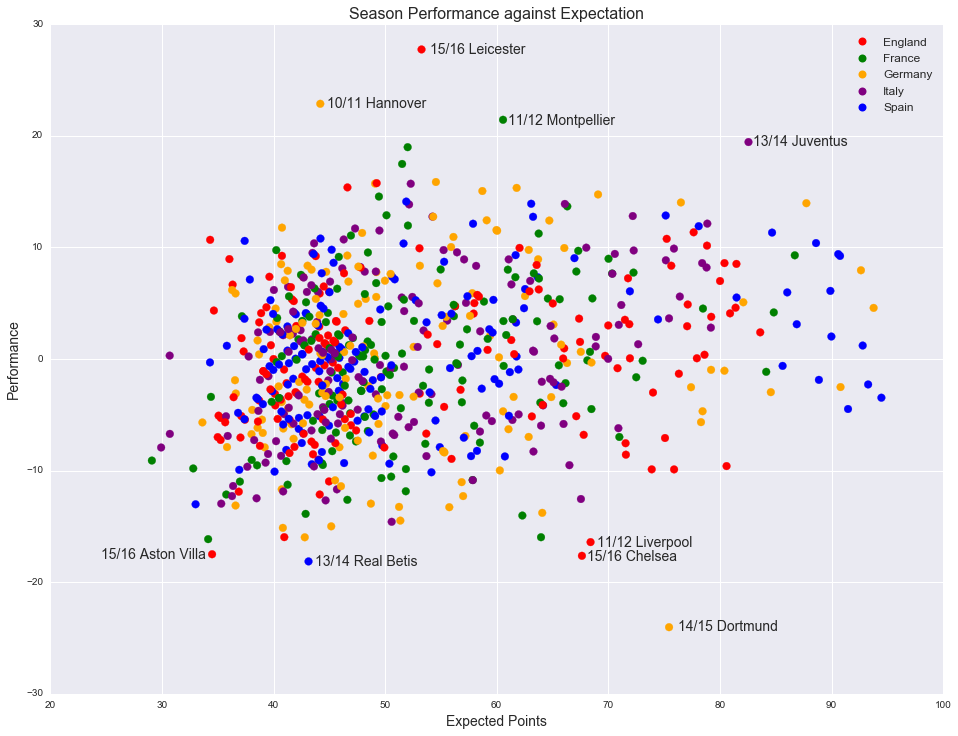

In [441]:
from matplotlib.lines import Line2D

# average values
avgExp = np.mean(teamExp)
avgPfm = np.mean(teamPfm)


# plot
plt.figure(figsize=(16,12))
plt.scatter(exp, pfm, color=clr, s=[60]*len(exp))
plt.title('Season Performance against Expectation', fontsize=16)

# legend
circles = []
labels = []
for leagueID, name in zip(bigLeagues.id, bigLeagues.name_x):
    labels.append(name)
    circles.append(Line2D([0], [0], linestyle="none", marker="o", markersize=8, markerfacecolor=colors_mapping[leagueID]))
plt.legend(circles, labels, numpoints=1, loc=(0.89, 0.86), prop={'size': 12})

# annotation
plt.xlabel('Expected Points', fontsize=14)
plt.ylabel('Performance', fontsize=14)

ax = plt.gca()
plt.ylim((-30,30))
ax.annotate('15/16 Leicester', xy=(54, 27.3), fontsize=14)
ax.annotate('10/11 Hannover', xy=(44.8, 22.5), fontsize=14)
ax.annotate('11/12 Montpellier', xy=(61, 21), fontsize=14)
ax.annotate('13/14 Juventus', xy=(83, 19.1), fontsize=14)
ax.annotate('14/15 Dortmund', xy=(76.2, -24.4), fontsize=14)
ax.annotate('15/16 Chelsea', xy=(68.1, -18.1), fontsize=14)
ax.annotate('11/12 Liverpool', xy=(69, -16.8), fontsize=14)
ax.annotate('13/14 Real Betis', xy=(43.7, -18.5), fontsize=14)
ax.annotate('15/16 Aston Villa', xy=(24.5, -17.9), fontsize=14)


### Teams exceeded expectations

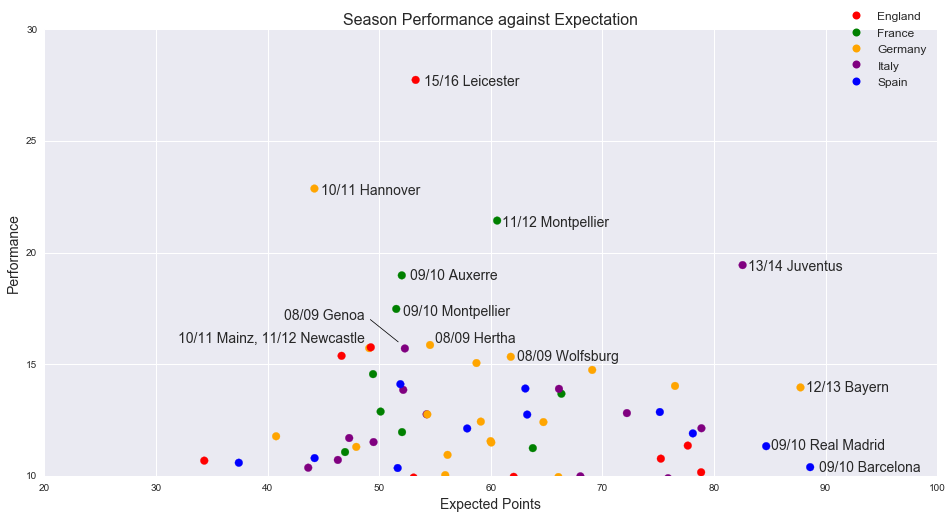

In [478]:
# Teams exceeded expectations 超出期望球队

# plot
plt.figure(figsize=(16,8))
plt.scatter(exp, pfm, color=clr, s=[60]*len(exp))
plt.title('Season Performance against Expectation', fontsize=16)

# legend
circles = []
labels = []
for leagueID, name in zip(bigLeagues.id, bigLeagues.name_x):
    labels.append(name)
    circles.append(Line2D([0], [0], linestyle="none", marker="o", markersize=8, markerfacecolor=colors_mapping[leagueID]))
plt.legend(circles, labels, numpoints=1, loc=(0.89, 0.86), prop={'size': 12})

# annotation
plt.xlabel('Expected Points', fontsize=14)
plt.ylabel('Performance', fontsize=14)

ax = plt.gca()
plt.ylim((10, 30))

ax.annotate('15/16 Leicester', xy=(54, 27.5), fontsize=14)
ax.annotate('10/11 Hannover', xy=(44.8, 22.6), fontsize=14)
ax.annotate('11/12 Montpellier', xy=(61, 21.2), fontsize=14)
ax.annotate('13/14 Juventus', xy=(83, 19.2), fontsize=14)
ax.annotate('12/13 Bayern', xy=(88.2, 13.8), fontsize=14)
ax.annotate('09/10 Real Madrid', xy=(85.1, 11.2), fontsize=14)
ax.annotate('09/10 Barcelona', xy=(89.4, 10.2), fontsize=14)
ax.annotate('09/10 Auxerre', xy=(52.8, 18.8), fontsize=14)
ax.annotate('09/10 Montpellier', xy=(52.1, 17.2), fontsize=14)
ax.annotate('08/09 Wolfsburg', xy=(62.3, 15.2), fontsize=14)
ax.annotate('08/09 Genoa', xy=(41.5, 17), fontsize=14)
plt.plot([49.2, 51.7], [17, 16], 'k-', lw=0.75)
ax.annotate('08/09 Hertha', xy=(55, 16), fontsize=14)
ax.annotate('10/11 Mainz, 11/12 Newcastle', xy=(32, 16), fontsize=14)

### Teams failed to deliver

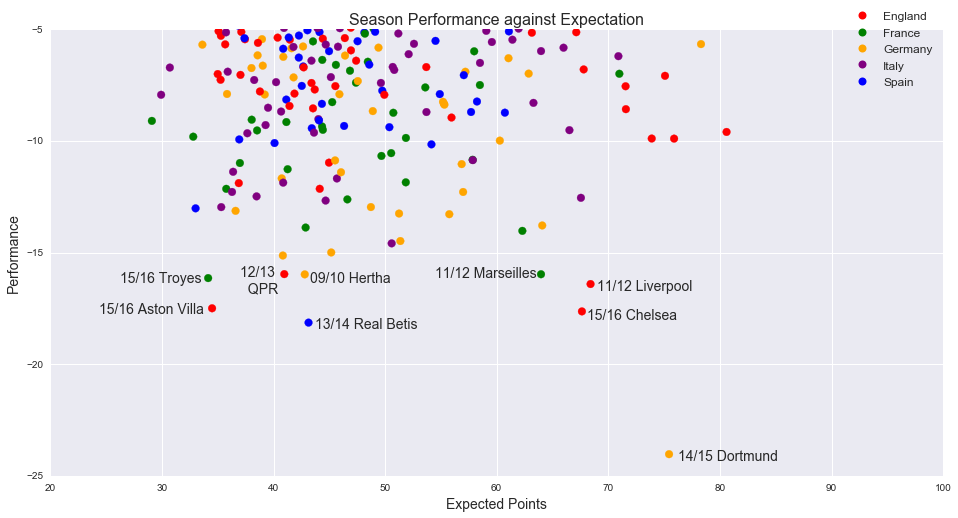

In [484]:
# Teams failed to deliver 低于期望球队

# plot
plt.figure(figsize=(16,8))
plt.scatter(exp, pfm, color=clr, s=[60]*len(exp))
plt.title('Season Performance against Expectation', fontsize=16)

# legend
circles = []
labels = []
for leagueID, name in zip(bigLeagues.id, bigLeagues.name_x):
    labels.append(name)
    circles.append(Line2D([0], [0], linestyle="none", marker="o", markersize=8, markerfacecolor=colors_mapping[leagueID]))
plt.legend(circles, labels, numpoints=1, loc=(0.89, 0.86), prop={'size': 12})

# annotation
plt.xlabel('Expected Points', fontsize=14)
plt.ylabel('Performance', fontsize=14)

ax = plt.gca()
plt.ylim((-25,-5))
ax.annotate('14/15 Dortmund', xy=(76.2, -24.3), fontsize=14)
ax.annotate('15/16 Chelsea', xy=(68.1, -18), fontsize=14)
ax.annotate('11/12 Liverpool', xy=(69, -16.7), fontsize=14)
ax.annotate('13/14 Real Betis', xy=(43.7, -18.4), fontsize=14)
ax.annotate('15/16 Aston Villa', xy=(24.4, -17.7), fontsize=14)
ax.annotate('15/16 Troyes', xy=(26.2, -16.3), fontsize=14)
ax.annotate('09/10 Hertha', xy=(43.3, -16.3), fontsize=14)
ax.annotate('11/12 Marseilles', xy=(54.5, -16.1), fontsize=14)
ax.annotate('12/13 \n  QPR', xy=(37, -16.8), fontsize=14)

## Chinese Viz

In [285]:
# font path
import matplotlib.font_manager as mfm
font_path = '/Library/Fonts/华文细黑.ttf'
font = mfm.FontProperties(fname=font_path)
cnLeagueNames = ['英超', '法甲', '德甲', '意甲', '西甲']

### All teams

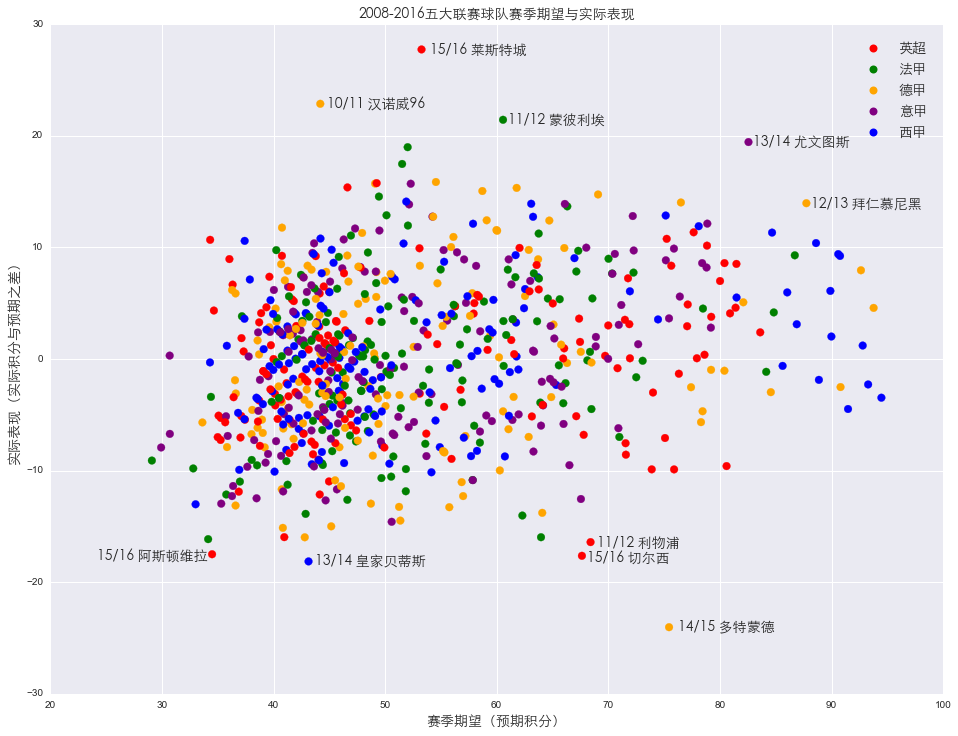

In [465]:
# All teams 所有球队

plt.figure(figsize=(16,12))
plt.scatter(exp, pfm, color=clr, s=[60]*len(exp))
plt.title('2008-2016五大联赛球队赛季期望与实际表现', fontsize=16, fontproperties=font)

circles = []
labels = []
for leagueID, name in zip(bigLeagues.id, cnLeagueNames):
    labels.append(name)
    circles.append(Line2D([0], [0], linestyle="none", marker="o", markersize=8, markerfacecolor=colors_mapping[leagueID]))
plt.legend(circles, labels, numpoints=1, loc=(0.9, 0.82), prop=font)

plt.ylim((-30,30))
plt.xlabel('赛季期望（预期积分）', fontsize=14, fontproperties=font)
plt.ylabel('实际表现（实际积分与预期之差）', fontsize=14, fontproperties=font)

ax = plt.gca()

ax.annotate('15/16 莱斯特城', xy=(54, 27.3), fontsize=14, fontproperties=font)
ax.annotate('10/11 汉诺威96', xy=(44.8, 22.4), fontsize=14, fontproperties=font)
ax.annotate('11/12 蒙彼利埃', xy=(61, 21), fontsize=14, fontproperties=font)
ax.annotate('13/14 尤文图斯', xy=(83, 19), fontsize=14, fontproperties=font)
ax.annotate('12/13 拜仁慕尼黑', xy=(88.2, 13.5), fontsize=14, fontproperties=font)
ax.annotate('14/15 多特蒙德', xy=(76.2, -24.4), fontsize=14, fontproperties=font)
ax.annotate('15/16 切尔西', xy=(68.1, -18.3), fontsize=14, fontproperties=font)
ax.annotate('11/12 利物浦', xy=(69, -16.9), fontsize=14, fontproperties=font)
ax.annotate('13/14 皇家贝蒂斯', xy=(43.7, -18.5), fontsize=14, fontproperties=font)
ax.annotate('15/16 阿斯顿维拉', xy=(24.2, -18.1), fontsize=14, fontproperties=font)

### Teams exceeded expectations

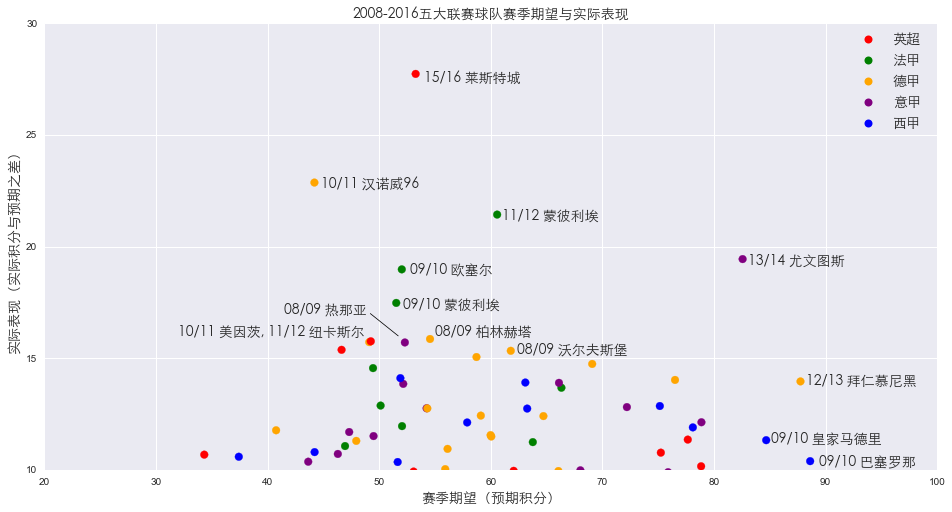

In [466]:
# Teams exceeded expectations 超出期望球队

plt.figure(figsize=(16,8))
plt.scatter(exp, pfm, color=clr, s=[60]*len(exp))
plt.title('2008-2016五大联赛球队赛季期望与实际表现', fontsize=16, fontproperties=font)

circles = []
labels = []
for leagueID, name in zip(bigLeagues.id, cnLeagueNames):
    labels.append(name)
    circles.append(Line2D([0], [0], linestyle="none", marker="o", markersize=8, markerfacecolor=colors_mapping[leagueID]))
plt.legend(circles, labels, numpoints=1, loc=(0.9, 0.75), prop=font)

plt.ylim((10,30))
plt.xlabel('赛季期望（预期积分）', fontsize=14, fontproperties=font)
plt.ylabel('实际表现（实际积分与预期之差）', fontsize=14, fontproperties=font)

ax = plt.gca()

ax.annotate('15/16 莱斯特城', xy=(54, 27.4), fontsize=14, fontproperties=font)
ax.annotate('10/11 汉诺威96', xy=(44.8, 22.6), fontsize=14, fontproperties=font)
ax.annotate('11/12 蒙彼利埃', xy=(61, 21.2), fontsize=14, fontproperties=font)
ax.annotate('13/14 尤文图斯', xy=(83, 19.2), fontsize=14, fontproperties=font)
ax.annotate('12/13 拜仁慕尼黑', xy=(88.2, 13.8), fontsize=14, fontproperties=font)
ax.annotate('09/10 皇家马德里', xy=(85.1, 11.2), fontsize=14, fontproperties=font)
ax.annotate('09/10 巴塞罗那', xy=(89.4, 10.2), fontsize=14, fontproperties=font)

ax.annotate('09/10 欧塞尔', xy=(52.8, 18.8), fontsize=14, fontproperties=font)
ax.annotate('09/10 蒙彼利埃', xy=(52.1, 17.2), fontsize=14, fontproperties=font)
ax.annotate('08/09 沃尔夫斯堡', xy=(62.3, 15.2), fontsize=14, fontproperties=font)
ax.annotate('08/09 热那亚', xy=(41.5, 17), fontsize=14, fontproperties=font)
plt.plot([49.2, 51.7], [17, 16], 'k-', lw=0.75)
ax.annotate('08/09 柏林赫塔', xy=(55, 16), fontsize=14, fontproperties=font)
ax.annotate('10/11 美因茨, 11/12 纽卡斯尔', xy=(32, 16), fontsize=14, fontproperties=font)

### Teams failed to deliver

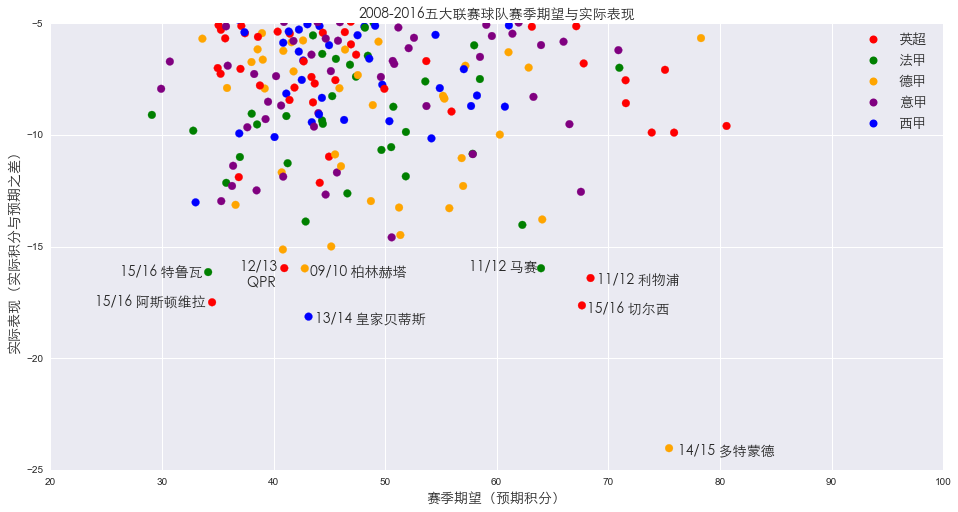

In [469]:
# Teams failed to deliver 低于期望球队

plt.figure(figsize=(16,8))
plt.scatter(exp, pfm, color=clr, s=[60]*len(exp))
plt.title('2008-2016五大联赛球队赛季期望与实际表现', fontsize=16, fontproperties=font)

circles = []
labels = []
for leagueID, name in zip(bigLeagues.id, cnLeagueNames):
    labels.append(name)
    circles.append(Line2D([0], [0], linestyle="none", marker="o", markersize=8, markerfacecolor=colors_mapping[leagueID]))
plt.legend(circles, labels, numpoints=1, loc=(0.9, 0.75), prop=font)

plt.ylim((-25,-5))
plt.xlabel('赛季期望（预期积分）', fontsize=14, fontproperties=font)
plt.ylabel('实际表现（实际积分与预期之差）', fontsize=14, fontproperties=font)

ax = plt.gca()

ax.annotate('14/15 多特蒙德', xy=(76.2, -24.3), fontsize=14, fontproperties=font)
ax.annotate('15/16 切尔西', xy=(68.1, -18), fontsize=14, fontproperties=font)
ax.annotate('11/12 利物浦', xy=(69, -16.7), fontsize=14, fontproperties=font)
ax.annotate('13/14 皇家贝蒂斯', xy=(43.7, -18.4), fontsize=14, fontproperties=font)
ax.annotate('15/16 阿斯顿维拉', xy=(24, -17.7), fontsize=14, fontproperties=font)
ax.annotate('15/16 特鲁瓦', xy=(26.2, -16.3), fontsize=14, fontproperties=font)
ax.annotate('09/10 柏林赫塔', xy=(43.3, -16.3), fontsize=14, fontproperties=font)
ax.annotate('11/12 马赛', xy=(57.5, -16.1), fontsize=14, fontproperties=font)
ax.annotate('12/13 \n  QPR', xy=(37, -16.8), fontsize=14, fontproperties=font)

## Reference

[This](https://www.kaggle.com/yonilev/the-most-predictable-league) kaggle kernel was __heavily__ referred to.